In [1]:
import gc
def report_gpu(): 
    print(torch.cuda.list_gpu_processes()) 
    gc.collect() 
    torch.cuda.empty_cache()

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Look into the data directory
data_dir = "/kaggle/input/deepfake-and-real-images/Dataset"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Train")
print(classes)

['Validation', 'Test', 'Train']
['Fake', 'Real']


In [4]:
import torchvision.transforms as tt

train_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Resize((128,128))
])

valid_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Resize((128,128))
])


In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/Train', train_tfms)
valid_ds = ImageFolder(data_dir+'/Test', valid_tfms)

In [6]:
real = os.listdir(data_dir + "/Train/Real")
print('No. of training examples for Real:', len(real))
print(real[:5])

No. of training examples for Real: 70001
['real_58276.jpg', 'real_36415.jpg', 'real_1646.jpg', 'real_51062.jpg', 'real_69849.jpg']


In [7]:
real = os.listdir(data_dir + "/Test/Real")
print('No. of testing examples for Real:', len(real))
print(real[:5])

No. of testing examples for Real: 5413
['real_1646.jpg', 'real_332.jpg', 'real_2402.jpg', 'real_1008.jpg', 'real_4846.jpg']


In [ ]:
real = os.listdir(data_dir + "/Test/Fake")
print('No. of testing examples for Fake:', len(real))
print(real[:5])

No. of testing examples for Fake: 5492
['fake_1068.jpg', 'fake_3016.jpg', 'fake_4215.jpg', 'fake_1467.jpg', 'fake_4367.jpg']


In [ ]:
fake = os.listdir(data_dir + "/Train/Fake")
print('No. of training examples for fake:', len(fake))
print(fake[:5])

No. of training examples for fake: 70001
['fake_12723.jpg', 'fake_24129.jpg', 'fake_21071.jpg', 'fake_13601.jpg', 'fake_43500.jpg']


In [ ]:
batch_size=64

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

In [ ]:
for images, labels in train_dl:
    print(images.shape)
    break

torch.Size([64, 3, 128, 128])


In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        # denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

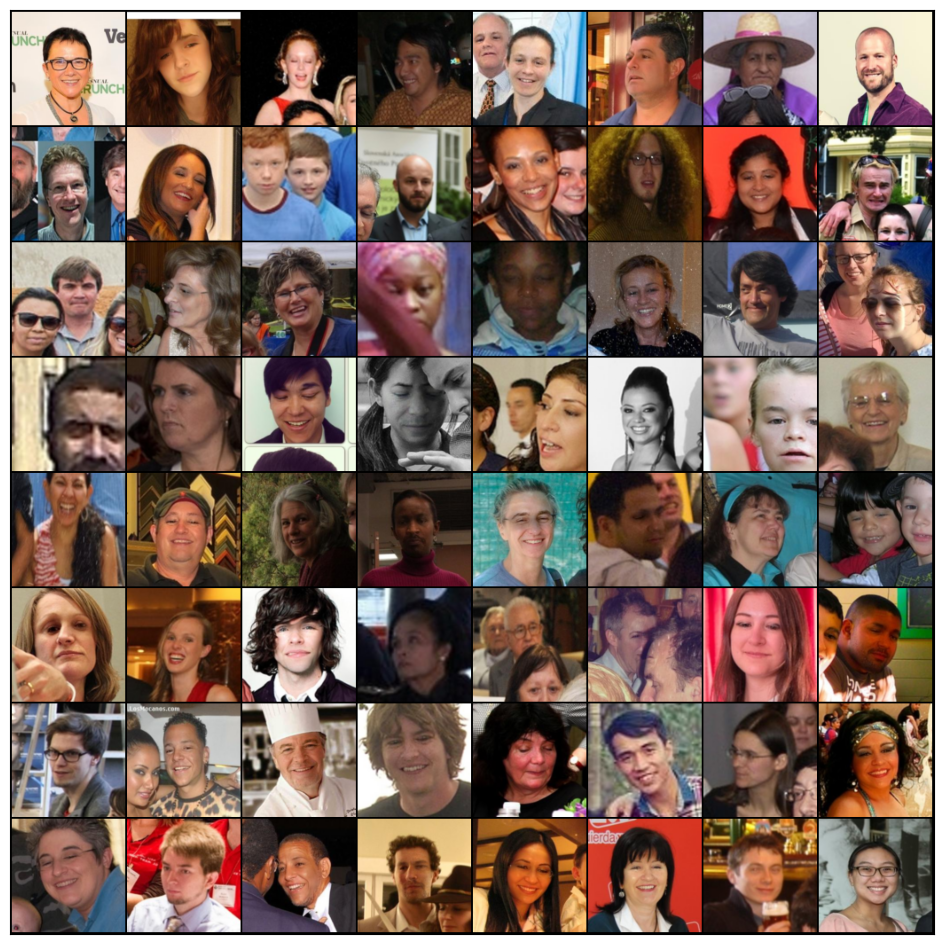

In [ ]:
show_batch(train_dl)

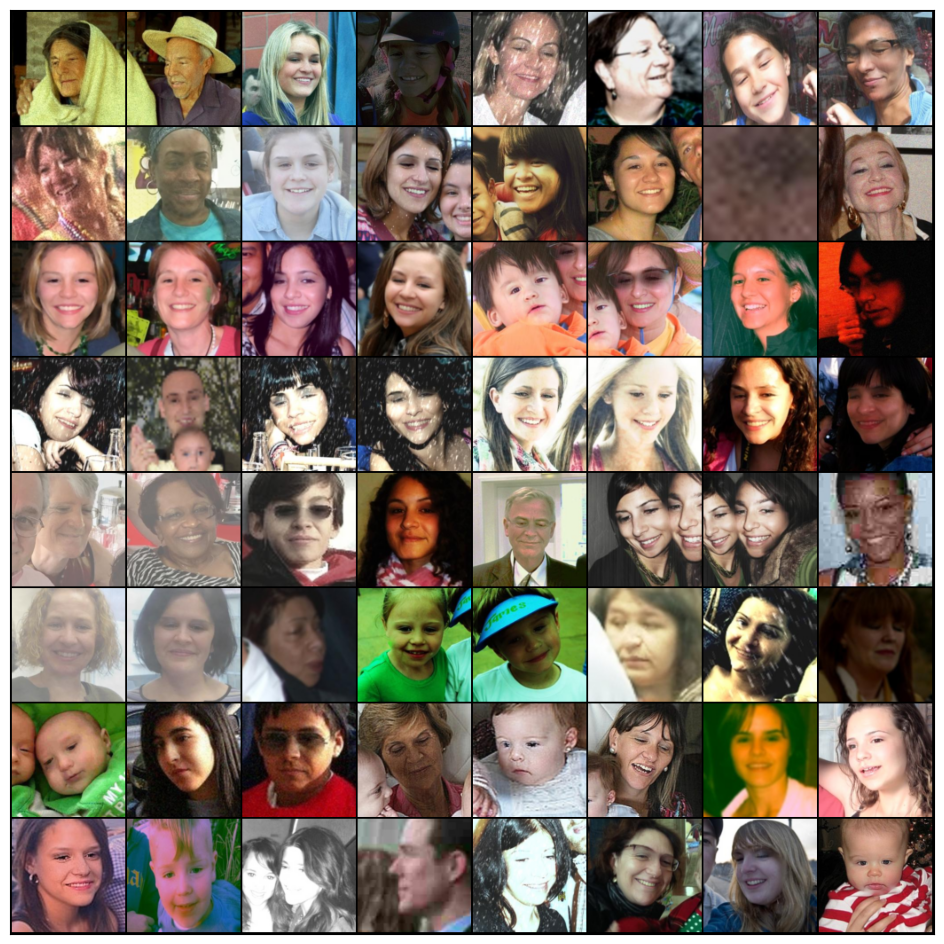

In [ ]:
show_batch(valid_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def metrics(outputs, labels):
    _, preds = torch.max(outputs, dim=1)  # Get predicted class
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    
    return {
        'accuracy': torch.tensor(acc),
        'precision': torch.tensor(precision),
        'recall': torch.tensor(recall),
        'f1_score': torch.tensor(f1)
    }


In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels)   
        metric_values = metrics(out, labels) 
        
        return {
            'val_loss': loss.detach(), 
            'val_acc': metric_values['accuracy'],
            'val_precision': metric_values['precision'],
            'val_recall': metric_values['recall'],
            'val_f1': metric_values['f1_score']
        }


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        
        batch_accs = [x['val_acc'] for x in outputs]
        batch_precisions = [x['val_precision'] for x in outputs]
        batch_recalls = [x['val_recall'] for x in outputs]
        batch_f1s = [x['val_f1'] for x in outputs]
    
        epoch_acc = torch.stack(batch_accs).mean()
        epoch_precision = torch.stack(batch_precisions).mean()
        epoch_recall = torch.stack(batch_recalls).mean()
        epoch_f1 = torch.stack(batch_f1s).mean()
    
        return {
            'val_loss': epoch_loss.item(), 
            'val_acc': epoch_acc.item(),
            'val_precision': epoch_precision.item(),
            'val_recall': epoch_recall.item(),
            'val_f1': epoch_f1.item()
        }

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_prec: {:.4f}, val_rec: {:.4f}, val_f1: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], 
            result['val_acc'], result['val_precision'], result['val_recall'], result['val_f1']))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [ ]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class CustomResidualNetwork(ImageClassificationBase):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def getModel(): 
    return CustomResidualNetwork(n_groups=3, N=3, n_classes=2, k=6)

In [ ]:
model = to_device(getModel(), device)
model

CustomResidualNetwork(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import os

CHECKPOINT_PATH = "model_checkpoint_deepfake_and_real.pth"

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

def save_checkpoint(epoch, model, optimizer, scheduler, history):
    """Save model checkpoint locally."""
    CHECKPOINT_PATH = "model_checkpoint_deepfake_and_real.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),  # Save scheduler
        'history': history
    }, CHECKPOINT_PATH)
    print(f"Checkpoint saved at epoch {epoch+1}")

    
def load_checkpoint(model, optimizer, scheduler):
    """Load model checkpoint if available."""
    if os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])  # Load scheduler
        history = checkpoint['history']
        start_epoch = checkpoint['epoch'] + 1
        
        # Ensure correct LR after restoring
        for param_group in optimizer.param_groups:
            param_group['lr'] = get_lr(optimizer)
        
        print(f"Resuming training from epoch {start_epoch}, with LR: {get_lr(optimizer)}")
        return start_epoch, history
    return 0, []

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    
    # Define OneCycleLR scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    # Load checkpoint if available
    start_epoch, history = load_checkpoint(model, optimizer, sched)

    for epoch in range(start_epoch, epochs):  # Start from last saved epoch
        model.train()
        train_losses = []
        lrs = []
        
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for batch in pbar:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                
                if grad_clip: 
                    nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
                optimizer.step()
                sched.step()  # Move AFTER optimizer step
                optimizer.zero_grad()
                
                lrs.append(get_lr(optimizer))
                pbar.set_postfix(loss=loss.item(), lr=lrs[-1])
        
        # Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer, sched, history)

    return history


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6934751868247986,
  'val_acc': 0.49817251461988304,
  'val_precision': 0.497281615497076,
  'val_recall': 0.49817251461988304,
  'val_f1': 0.49742228377962444}]

In [ ]:
epochs = 5
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.AdamW

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

<ipython-input-25-db1a3e5d2b8d>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cuda' if torch.cuda.is_

Resuming training from epoch 3, with LR: 0.0030553101888728114


Epoch 4/5: 100%|██████████| 2188/2188 [1:00:18<00:00,  1.65s/batch, loss=0.107, lr=0.00094]  


Epoch [3], last_lr: 0.0009, train_loss: 0.0525, val_loss: 0.2254, val_acc: 0.9186, val_prec: 0.9997, val_rec: 0.9186, val_f1: 0.9564
Checkpoint saved at epoch 4


Epoch 5/5: 100%|██████████| 2188/2188 [1:00:17<00:00,  1.65s/batch, loss=0.000279, lr=2.02e-8]


Epoch [4], last_lr: 0.0000, train_loss: 0.0303, val_loss: 0.2550, val_acc: 0.9220, val_prec: 1.0000, val_rec: 0.9220, val_f1: 0.9580
Checkpoint saved at epoch 5
CPU times: user 2h 3min 42s, sys: 30.9 s, total: 2h 4min 13s
Wall time: 2h 3min 34s


In [ ]:
torch.save(model.state_dict(), 'deepfake_and_real_draft_1.pth')

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(len(history))
    
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, [x.get('train_loss') for x in history], label='Train Loss')
    plt.plot(epochs, [x['val_loss'] for x in history], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    
    # Accuracy, Precision, Recall, F1-score plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [x['val_acc'] for x in history], label='Accuracy')
    plt.plot(epochs, [x['val_precision'] for x in history], label='Precision')
    plt.plot(epochs, [x['val_recall'] for x in history], label='Recall')
    plt.plot(epochs, [x['val_f1'] for x in history], label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Performance Metrics Over Epochs')
    
    plt.show()


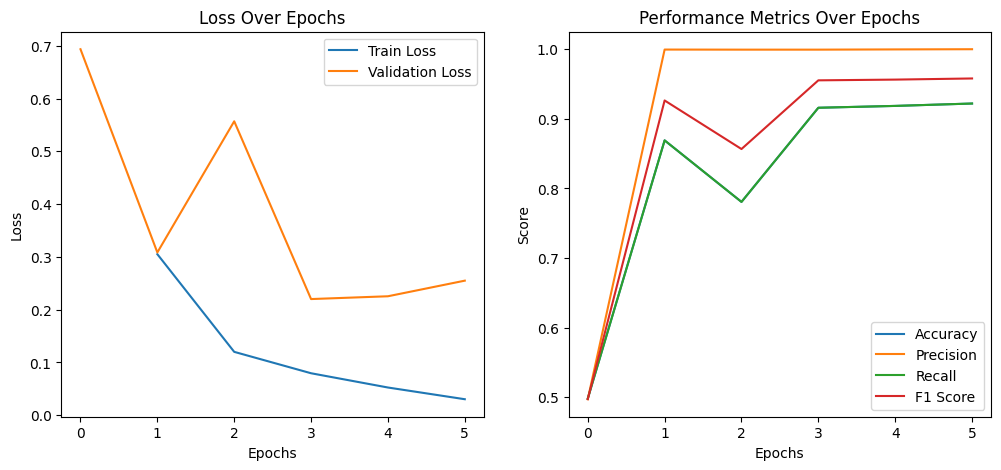

In [ ]:
plot_metrics(history)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

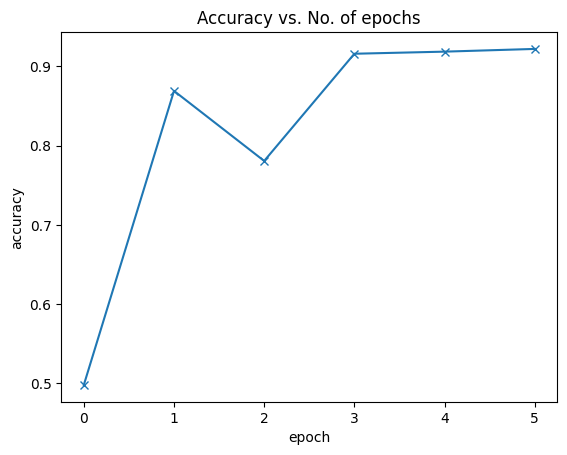

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

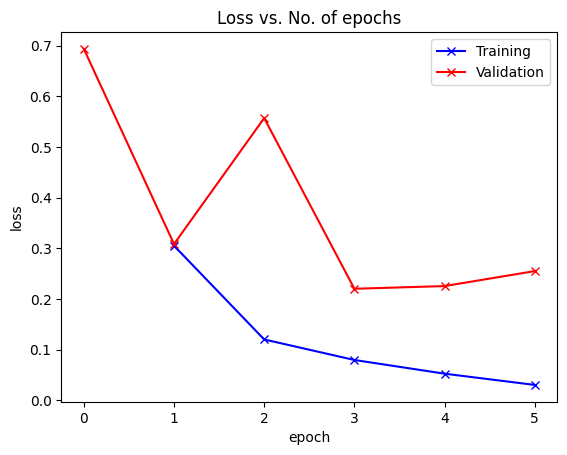

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

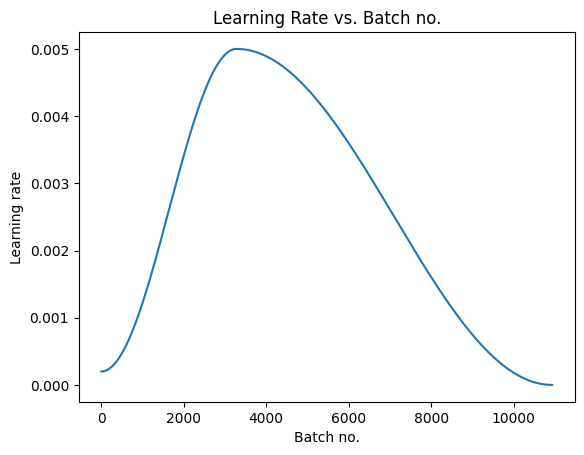

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Fake , Predicted: Fake


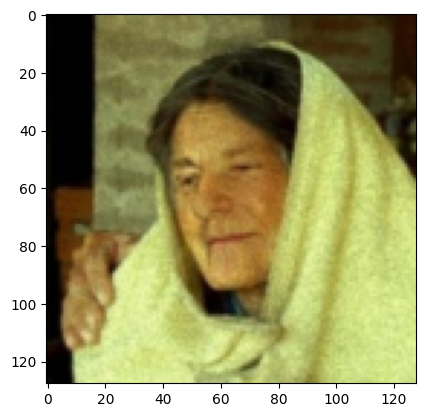

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Fake , Predicted: Fake


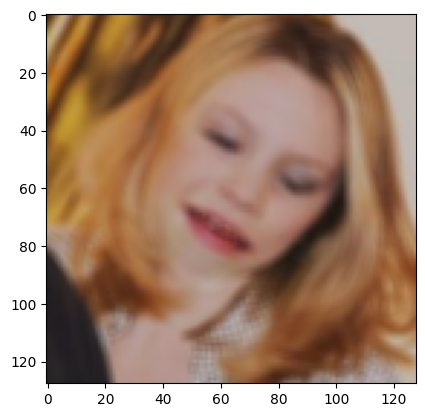

In [ ]:
img, label = valid_ds[2298]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Fake , Predicted: Fake


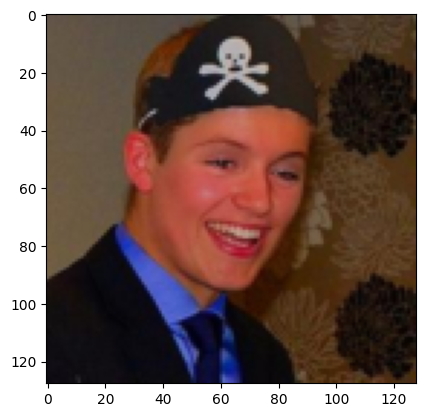

In [ ]:
img, label = valid_ds[1456]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))